In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pyproj
import scipy.signal
import sys
import numpy as np
import datetime
%matplotlib inline

In [28]:
#coordinate conversion lat-lon to nzmg
def deg2nzmg(lon,lat):
    # define projections
    proj_wgs84 = pyproj.Proj(init="epsg:4326")
    proj_nzmg = pyproj.Proj(init="epsg:27200")
    # convert coordinates from deg to NZMG
    e,n = pyproj.transform(proj_wgs84,proj_nzmg,lon,lat)
    # return Easting and Northing in NZMG
    return e,n

filter kernel

In [29]:
od = 11

days for FITS query ***alter for a different time length ***

In [30]:
days = '365'

In [31]:
site1 = 'RGWI.CG'
site2 = 'RGWC.CG'
siteid1 = str.split(site1, '.')[0]
netid1 = str.split(site1, '.')[1]
siteid2 = str.split(site2, '.')[0]
netid2 = str.split(site2, '.')[1]

position data for site1

In [32]:
url = 'http://fits.geonet.org.nz/site'
payload = {'siteID': siteid1, 'networkID': netid1}
r = requests.get(url,params=payload)
#get from a dictionary
jdata = r.json()
lon = jdata.values()[1][0]['geometry']['coordinates'][0]
lat = jdata.values()[1][0]['geometry']['coordinates'][1]
pos_e, pos_n = deg2nzmg(lon, lat);
pos_z = jdata.values()[1][0]['properties']['height']
#convert to mm
pos_e *= 1000
pos_n *= 1000
pos_z *= 1000
pos_e1 = pos_e
pos_n1 = pos_n
pos_z1 = pos_z

position data for site2

In [33]:
url = 'http://fits.geonet.org.nz/site'
payload = {'siteID': siteid2, 'networkID': netid2}
r = requests.get(url,params=payload)
#get from a dictionary
jdata = r.json()
lon = jdata.values()[1][0]['geometry']['coordinates'][0]
lat = jdata.values()[1][0]['geometry']['coordinates'][1]
pos_e, pos_n = deg2nzmg(lon, lat);
pos_z = jdata.values()[1][0]['properties']['height']
#convert to mm
pos_e *= 1000
pos_n *= 1000
pos_z *= 1000
pos_e2 = pos_e
pos_n2 = pos_n
pos_z2 = pos_z

time series data for sites, FITS query
site1

In [34]:
names = ['dt', 'obs', 'err']
url= 'http://fits.geonet.org.nz/observation?typeID=e&siteID='+siteid1+'&networkID='+netid1+'&days='+days
df1e = pd.read_csv(url, names=names, skiprows=1, parse_dates={"Datetime" : ['dt']})
url= 'http://fits.geonet.org.nz/observation?typeID=n&siteID='+siteid1+'&networkID='+netid1+'&days='+days
df1n = pd.read_csv(url, names=names, skiprows=1, parse_dates={"Datetime" : ['dt']})
url= 'http://fits.geonet.org.nz/observation?typeID=u&siteID='+siteid1+'&networkID='+netid1+'&days='+days
df1u = pd.read_csv(url, names=names, skiprows=1, parse_dates={"Datetime" : ['dt']})

site2

In [35]:
url = 'http://fits.geonet.org.nz/observation?typeID=e&siteID='+siteid2+'&networkID='+netid2+'&days='+days
df2e = pd.read_csv(url, names=names, skiprows=1, parse_dates={"Datetime" : ['dt']})
url = 'http://fits.geonet.org.nz/observation?typeID=n&siteID='+siteid2+'&networkID='+netid2+'&days='+days
df2n = pd.read_csv(url, names=names, skiprows=1, parse_dates={"Datetime" : ['dt']})
url = 'http://fits.geonet.org.nz/observation?typeID=u&siteID='+siteid2+'&networkID='+netid2+'&days='+days
df2u = pd.read_csv(url, names=names, skiprows=1, parse_dates={"Datetime" : ['dt']})

use only Datetimes common to both sites,then reset indices

In [36]:
df1ea = df1e[df1e.Datetime.isin(df2e.Datetime)]
df1na = df1n[df1n.Datetime.isin(df2n.Datetime)]
df1ua = df1u[df1u.Datetime.isin(df2u.Datetime)]
df2ea = df2e[df2e.Datetime.isin(df1e.Datetime)]
df2na = df2n[df2n.Datetime.isin(df1n.Datetime)]
df2ua = df2u[df2u.Datetime.isin(df1u.Datetime)]

df1ea = df1ea.reset_index(drop=True)
df1na = df1na.reset_index(drop=True)
df1ua = df1ua.reset_index(drop=True)
df2ea = df2ea.reset_index(drop=True)
df2na = df2na.reset_index(drop=True)
df2ua = df2ua.reset_index(drop=True)

join dataframes, rename columns

In [37]:
df = pd.concat([df1ea, df1na, df1ua, df2ea, df2na, df2ua], axis=1, join='inner')
names = ['Datetime', 'obse1', 'erre1', 'dtn1', 'obsn1', 'errn1', 'dtu1', 'obsu1', 'erru1', 'dte2', 'obse2', 'erre2', 'dtn2', 'obsn2', 'errn2', 'dtu2', 'obsu2', 'erru2']
df.columns = names

add absolute positions

In [38]:
df['obse1'] = df['obse1'] + pos_e1
df['obsn1'] = df['obsn1'] + pos_n1
df['obsu1'] = df['obsu1'] + pos_z1
df['obse2'] = df['obse2'] + pos_e2
df['obsn2'] = df['obsn2'] + pos_n2
df['obsu2'] = df['obsu2'] + pos_z2

filter positions

In [39]:
df['obse1f'] = scipy.signal.medfilt(df['obse1'],od)
df['obsn1f'] = scipy.signal.medfilt(df['obsn1'],od)
df['obsu1f'] = scipy.signal.medfilt(df['obsu1'],od)
df['obse2f'] = scipy.signal.medfilt(df['obse2'],od)
df['obsn2f'] = scipy.signal.medfilt(df['obsn2'],od)
df['obsu2f'] = scipy.signal.medfilt(df['obsu2'],od)

calculate 3D line lengths, usig unfiltered positions, reference to first value

In [40]:
df['le'] = df['obse1'] - df['obse2']
df['ln'] = df['obsn1'] - df['obsn2']
df['lu'] = df['obsu1'] - df['obsu2']
df['xyz'] = np.sqrt(np.square(df['le']) + np.square(df['ln']) + np.square(df['lu']))

df['xyz'] = df['xyz'] - df['xyz'][0]

filter line length

In [41]:
df['xyzf'] = scipy.signal.medfilt(df['xyz'],od)

reference positions to first

In [42]:
df['obse1'] = df['obse1'] - df['obse1'][0]
df['obsn1'] = df['obsn1'] - df['obsn1'][0]
df['obsu1'] = df['obsu1'] - df['obsu1'][0]
df['obse2'] = df['obse2'] - df['obse2'][0]
df['obsn2'] = df['obsn2'] - df['obsn2'][0]
df['obsu2'] = df['obsu2'] - df['obsu2'][0]

df['obse1f'] = df['obse1f'] - df['obse1f'][0]
df['obsn1f'] = df['obsn1f'] - df['obsn1f'][0]
df['obsu1f'] = df['obsu1f'] - df['obsu1f'][0]
df['obse2f'] = df['obse2f'] - df['obse2f'][0]
df['obsn2f'] = df['obsn2f'] - df['obsn2f'][0]
df['obsu2f'] = df['obsu2f'] - df['obsu2f'][0]

output CSV

In [43]:
df.to_csv(site1+'.e.csv', header=False, columns=['Datetime', 'obse1'], index=False)
df.to_csv(site1+'.n.csv', header=False, columns=['Datetime', 'obsn1'], index=False)
df.to_csv(site1+'.u.csv', header=False, columns=['Datetime', 'obsu1'], index=False)
df.to_csv(site2+'.e.csv', header=False, columns=['Datetime', 'obse2'], index=False)
df.to_csv(site2+'.n.csv', header=False, columns=['Datetime', 'obsn2'], index=False)
df.to_csv(site2+'.u.csv', header=False, columns=['Datetime', 'obsu2'], index=False)

df.to_csv('line.csv', header=False, columns=['Datetime', 'xyz'], index=False)

plot

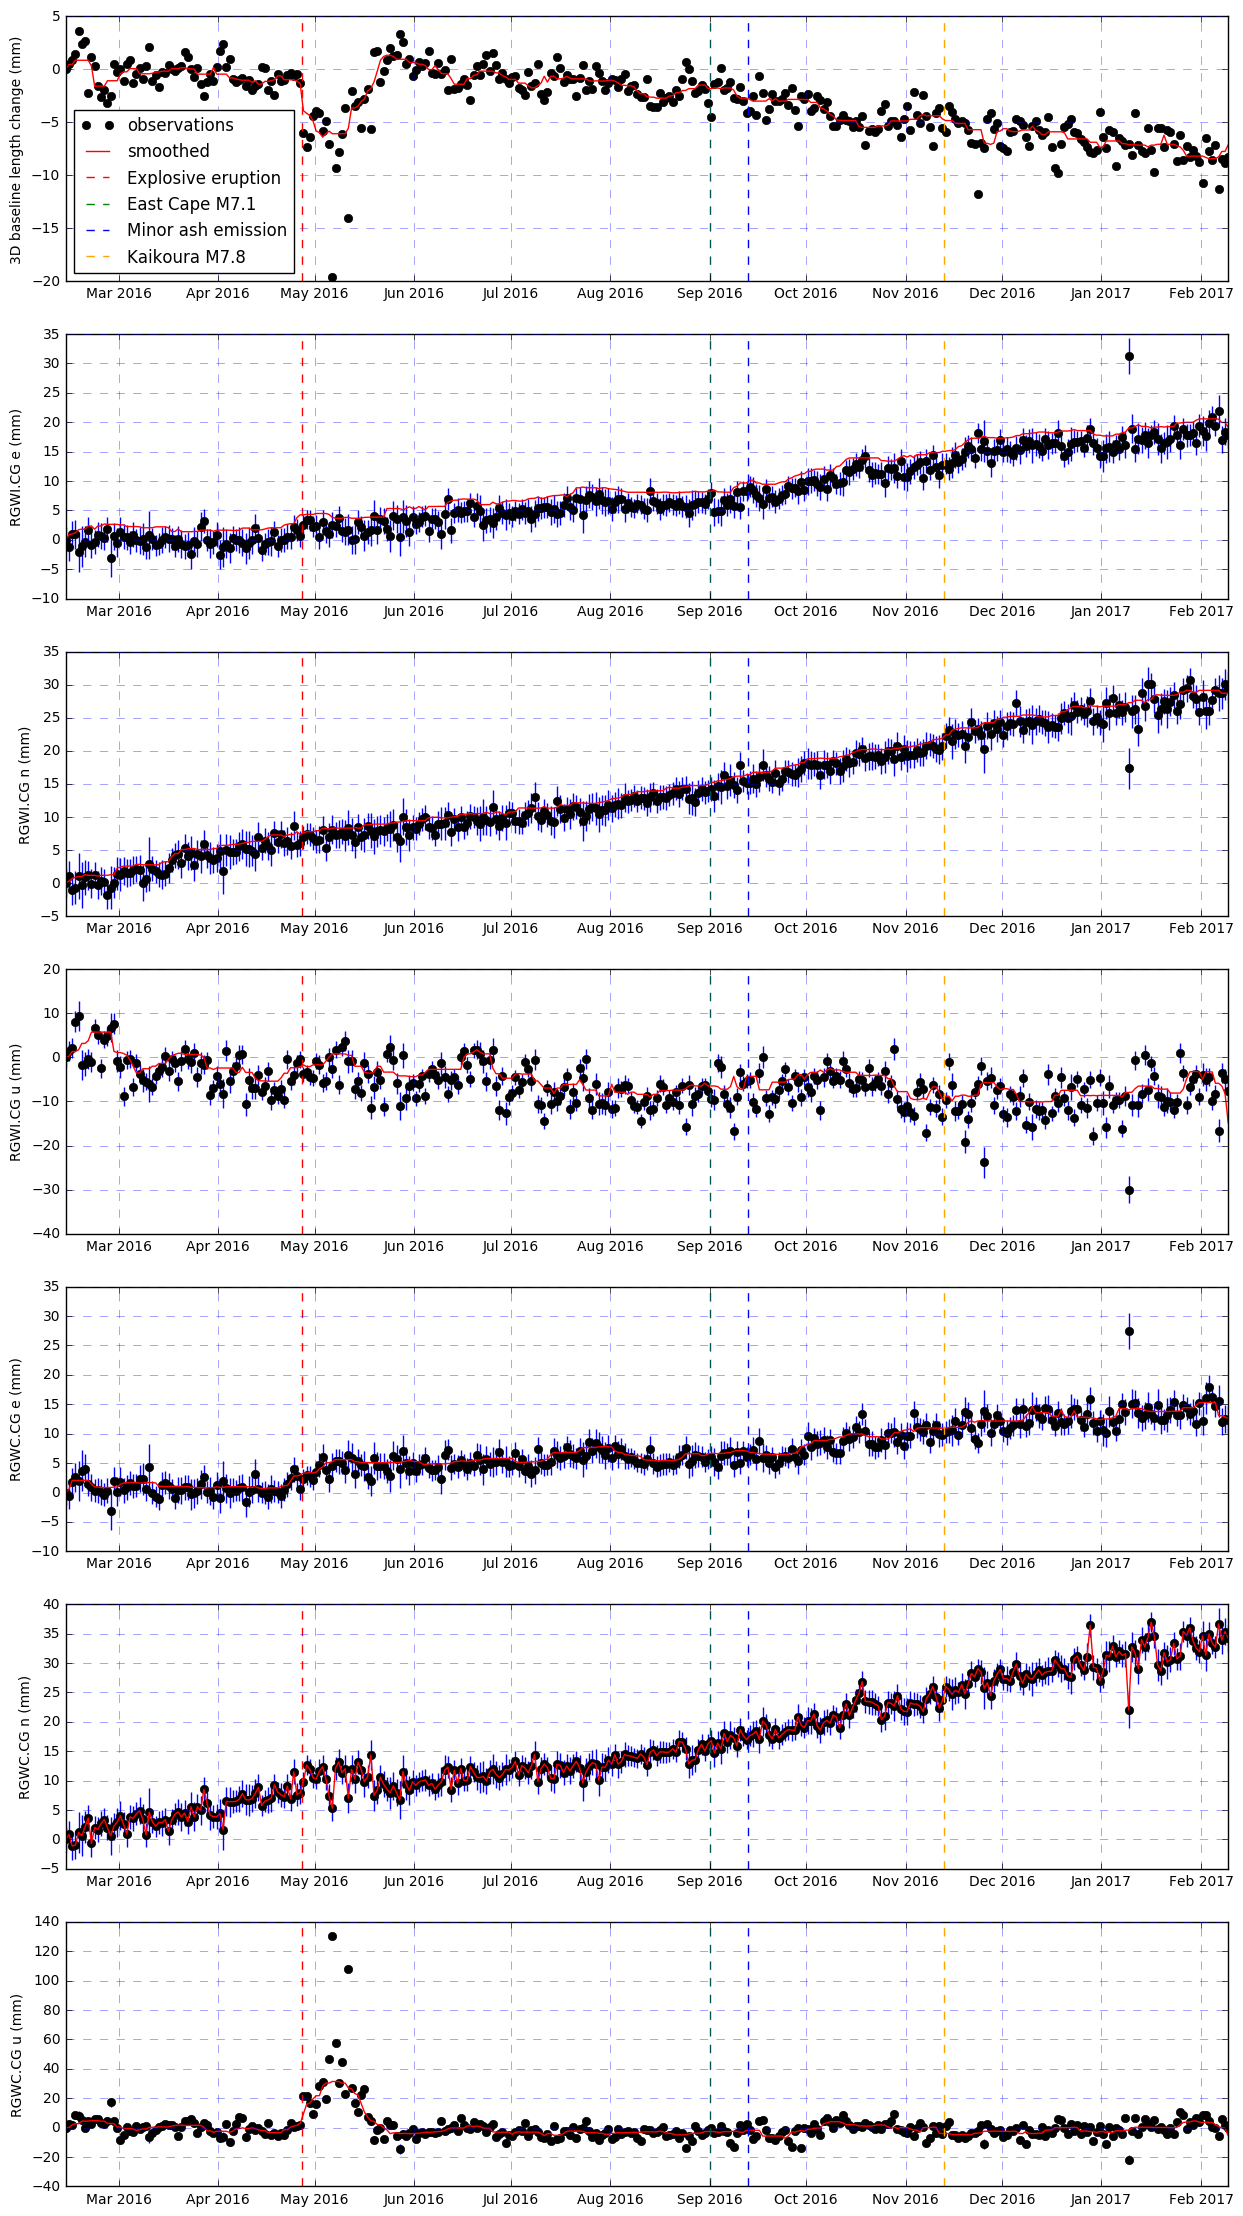

In [44]:
fig = plt.figure(figsize=(15, 28))

#line length
ax = fig.add_subplot(7, 1, 1)
plt.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
plt.plot(df['Datetime'], df['xyz'], marker='o', color='black',linestyle='None', label='observations')
plt.plot(df['Datetime'], df['xyzf'], marker='None', color='red', label='smoothed')
plt.ylabel('3D baseline length change (mm)')
plt.axvline(datetime.datetime.strptime('2016-04-27', '%Y-%m-%d').date(), color='red', linestyle='dashed', linewidth=1, label='Explosive eruption')
plt.axvline(datetime.datetime.strptime('2016-09-01', '%Y-%m-%d').date(), color='green', linestyle='dashed', linewidth=1, label='East Cape M7.1')
plt.axvline(datetime.datetime.strptime('2016-09-13', '%Y-%m-%d').date(), color='blue', linestyle='dashed', linewidth=1, label='Minor ash emission')
plt.axvline(datetime.datetime.strptime('2016-11-13', '%Y-%m-%d').date(), color='orange', linestyle='dashed', linewidth=1, label='Kaikoura M7.8')
plt.legend(loc='best')

#site1 e
ax = fig.add_subplot(7, 1, 2)
plt.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
plt.plot(df['Datetime'], df['obse1'], marker='o', color='black', linestyle='None')
plt.errorbar(df['Datetime'], df['obse1'], yerr=df['erre1'], capsize=0, linestyle='None')
plt.plot(df['Datetime'], df['obse1f'], marker='None', color='red')
plt.ylabel(site1+' e (mm)')
plt.axvline(datetime.datetime.strptime('2016-04-27', '%Y-%m-%d').date(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-09-01', '%Y-%m-%d').date(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-09-13', '%Y-%m-%d').date(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-11-13', '%Y-%m-%d').date(), color='orange', linestyle='dashed', linewidth=1)

#site1 n
ax = fig.add_subplot(7, 1, 3)
plt.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
plt.plot(df['Datetime'], df['obsn1'], marker='o', color='black', linestyle='None')
plt.errorbar(df['Datetime'], df['obsn1'], yerr=df['erre1'], capsize=0, linestyle='None')
plt.plot(df['Datetime'], df['obsn1f'], marker='None', color='red')
plt.ylabel(site1+' n (mm)')
plt.axvline(datetime.datetime.strptime('2016-04-27', '%Y-%m-%d').date(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-09-01', '%Y-%m-%d').date(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-09-13', '%Y-%m-%d').date(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-11-13', '%Y-%m-%d').date(), color='orange', linestyle='dashed', linewidth=1)

#site1 u
ax = fig.add_subplot(7, 1, 4)
plt.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
plt.plot(df['Datetime'], df['obsu1'], marker='o', color='black', linestyle='None')
plt.errorbar(df['Datetime'], df['obsu1'], yerr=df['erre1'], capsize=0, linestyle='None')
plt.plot(df['Datetime'], df['obsu1f'], marker='None', color='red')
plt.ylabel(site1+' u (mm)')
plt.axvline(datetime.datetime.strptime('2016-04-27', '%Y-%m-%d').date(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-09-01', '%Y-%m-%d').date(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-09-13', '%Y-%m-%d').date(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-11-13', '%Y-%m-%d').date(), color='orange', linestyle='dashed', linewidth=1)

#site2 e
ax = fig.add_subplot(7, 1, 5)
plt.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
plt.plot(df['Datetime'], df['obse2'], marker='o', color='black', linestyle='None')
plt.errorbar(df['Datetime'], df['obse2'], yerr=df['erre1'], capsize=0, linestyle='None')
plt.plot(df['Datetime'], df['obse2f'], marker='None', color='red')
plt.ylabel(site2+' e (mm)')
plt.axvline(datetime.datetime.strptime('2016-04-27', '%Y-%m-%d').date(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-09-01', '%Y-%m-%d').date(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-09-13', '%Y-%m-%d').date(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-11-13', '%Y-%m-%d').date(), color='orange', linestyle='dashed', linewidth=1)

#site2 n
ax = fig.add_subplot(7, 1, 6)
plt.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
plt.plot(df['Datetime'], df['obsn2'], marker='o', color='black', linestyle='None')
plt.errorbar(df['Datetime'], df['obsn2'], yerr=df['erre1'], capsize=0, linestyle='None')
plt.plot(df['Datetime'], df['obsn2'], marker='None', color='red')
plt.ylabel(site2+' n (mm)')
plt.axvline(datetime.datetime.strptime('2016-04-27', '%Y-%m-%d').date(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-09-01', '%Y-%m-%d').date(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-09-13', '%Y-%m-%d').date(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-11-13', '%Y-%m-%d').date(), color='orange', linestyle='dashed', linewidth=1)

#site2 u
ax = fig.add_subplot(7, 1, 7)
plt.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
plt.plot(df['Datetime'], df['obsu2'], marker='o', color='black', linestyle='None')
plt.errorbar(df['Datetime'], df['obsu2'], yerr=df['erre1'], capsize=0, linestyle='None')
plt.plot(df['Datetime'], df['obsu2f'], marker='None', color='red')
plt.ylabel(site2+' u (mm)')
plt.axvline(datetime.datetime.strptime('2016-04-27', '%Y-%m-%d').date(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-09-01', '%Y-%m-%d').date(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-09-13', '%Y-%m-%d').date(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(datetime.datetime.strptime('2016-11-13', '%Y-%m-%d').date(), color='orange', linestyle='dashed', linewidth=1)

plt.savefig('white_is.png')